In [1]:
!pip install pymorphy2[fast]

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
from typing import List
import nltk
import string
import pymorphy2
import codecs

class PrepareNew():
  def __init__(self):
    self.morph = pymorphy2.MorphAnalyzer()
    self.tokenizer = nltk.WordPunctTokenizer()
    self.stopwords = set(line.strip() for line in codecs.open('gdrive/MyDrive/rus_stopwords.txt', "r", "utf_8_sig").readlines())

  def prepare_corp(self, news_list: List[str]):
    return [self.newstext2token(news_text) for news_text in news_list]

  def newstext2token(self, news_text: str):
      tokens = self.tokenizer.tokenize(news_text.lower())
      tokens_with_no_punct = [self.morph.parse(w)[0].normal_form for w in tokens if all(c not in string.punctuation for c in w)]
      tokens_base_forms = [w for w in tokens_with_no_punct if w not in self.stopwords and w.isalpha()]
      tokens_last = [w for w in tokens_base_forms if len(w)>1]
      return tokens_last


In [4]:
import os

from sqlalchemy import (
    create_engine,
    Column,
    Integer,
    String,
    ARRAY,
    DateTime,
    REAL,
)
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker


engine = create_engine("postgresql")

Base = declarative_base()


class Meduza(Base):
    __tablename__ = 'meduza'
    id = Column(Integer, primary_key=True)
    datetime = Column(DateTime)
    source = Column(String)
    link = Column(String, unique=True)
    title = Column(String)
    text = Column(String)
    locs = Column(ARRAY(String))
    pers = Column(ARRAY(String))
    orgs = Column(ARRAY(String))


class Kommersant(Base):
    __tablename__ = 'commersant'
    id = Column(Integer, primary_key=True)
    datetime = Column(DateTime)
    rubric = Column(ARRAY(String))
    link = Column(String, unique=True)
    title = Column(String)
    text = Column(String)
    locs = Column(ARRAY(String))
    pers = Column(ARRAY(String))
    orgs = Column(ARRAY(String))
    x = Column(REAL)
    y = Column(REAL)
    highlights = Column(String)

Base.metadata.bind = engine
Base.metadata.create_all(engine)

DBSession = sessionmaker(bind=engine)
session = DBSession()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
all_news = session.query(Kommersant).all()

In [6]:
raw_data = []

In [7]:
for item in all_news:
    raw_data.append(item.text)

In [8]:
my_corp = PrepareNew().prepare_corp(raw_data)

In [9]:
from gensim.models import Word2Vec
from gensim.models import Phrases
bigram_transformer = Phrases(my_corp)
embeddings = Word2Vec(bigram_transformer[my_corp], window=5, min_count=2).wv

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
type(embeddings)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [11]:
embeddings.most_similar('рубль', topn=10)

[('купиться', 0.7985431551933289),
 ('доходность', 0.7937945127487183),
 ('рублёвый', 0.7846713662147522),
 ('доллар', 0.7788153886795044),
 ('urals_баррель', 0.7776412963867188),
 ('маржа', 0.7727961540222168),
 ('перетекать', 0.772076427936554),
 ('евро', 0.7712692022323608),
 ('крепость', 0.7668431997299194),
 ('востребование', 0.7635690569877625)]

In [12]:
embeddings.save('word_vectors_DB.kv')

In [13]:
from gensim.models import KeyedVectors
import numpy as np
def text2vec(tokens: List[str], embeddings: KeyedVectors) -> np.ndarray:
    """
        question: токены
        embeddings: w2v модель
        
        return: векторное представление для новости
    """

    relevant=0
    words_vecs=np.zeros((embeddings.vector_size,))
    for word in tokens:
      if word in embeddings:
        words_vecs+=embeddings.word_vec(word, True)
        relevant+=1

    if relevant:
      words_vecs/=relevant
    return words_vecs


In [14]:
import pandas as pd
df = pd.DataFrame()

print(len(raw_data), len(my_corp))

df['full_text'] = raw_data
df['tokens'] = my_corp

15956 15956


In [15]:
data_vectors = np.array([text2vec(tokens, embeddings) for tokens in my_corp])

In [16]:
data_vectors.shape

(15956, 100)

In [17]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_vectors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15956 samples in 0.244s...
[t-SNE] Computed neighbors for 15956 samples in 65.474s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15956
[t-SNE] Computed conditional probabilities for sample 2000 / 15956
[t-SNE] Computed conditional probabilities for sample 3000 / 15956
[t-SNE] Computed conditional probabilities for sample 4000 / 15956
[t-SNE] Computed conditional probabilities for sample 5000 / 15956
[t-SNE] Computed conditional probabilities for sample 6000 / 15956
[t-SNE] Computed conditional probabilities for sample 7000 / 15956
[t-SNE] Computed conditional probabilities for sample 8000 / 15956
[t-SNE] Computed conditional probabilities for sample 9000 / 15956
[t-SNE] Computed conditional probabilities for sample 10000 / 15956
[t-SNE] Computed conditional probabilities for sample 11000 / 15956
[t-SNE] Computed conditional probabilities for sample 12000 / 15956
[t-SNE] Computed conditional probabilities for s

In [18]:
df['x'] = tsne_results[:,0]
df['y'] = tsne_results[:,1]

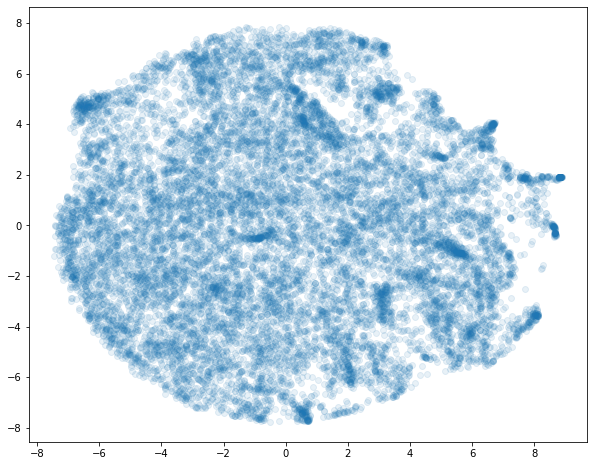

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

In [20]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = tsne_results
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.tokens.str.contains(pattern, regex=False)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = tsne_results
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = tsne_results[label_indices, 0]
    Ylabeled = tsne_results[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax


def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

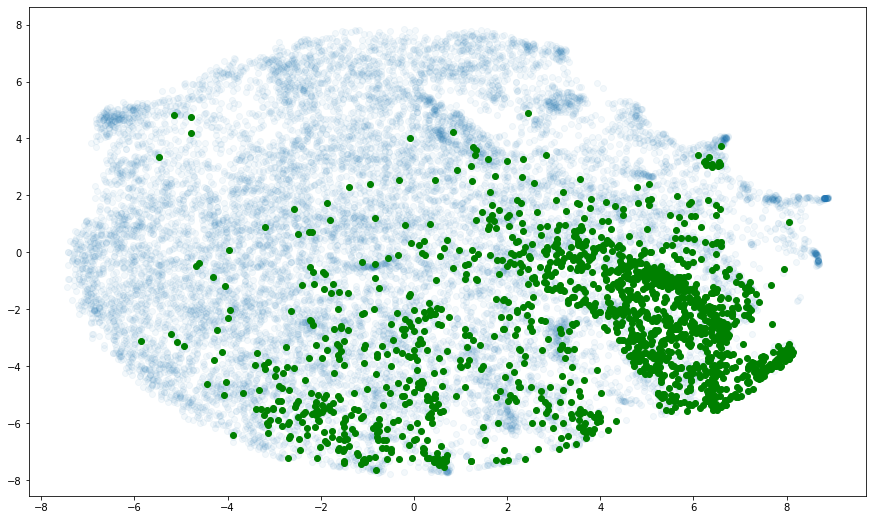

In [21]:
plot_by_title_pattern('инфляция', figsize=(15, 9), bg_alpha=.05, text=False);

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from typing import Tuple
def extract_keywords(tokens: List[str],
                     embeddings: KeyedVectors,
                     top_n: int = 5,
                     diversity: float = 0.5,
                     nr_candidates: int = 20) -> List[Tuple[str, float]]:
    
    # Extract Embeddings
    candidates = []
    doc_embedding = text2vec(tokens, embeddings).reshape(1, -1)
    candidate_embeddings = []
    for candidate in tokens:
        if candidate in embeddings:
            candidates.append(candidate)
            candidate_embeddings.append(embeddings[candidate])
            
    if len(candidates)==0:
        return tokens

    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [(candidates[index], round(float(distances[0][index]), 4))
                for index in distances.argsort()[0][-top_n:]][::-1]

    return keywords


In [23]:
print(extract_keywords(df.tokens[0], embeddings))

[('картина', 0.9352), ('открытость', 0.8793), ('здорово', 0.8461), ('понимание', 0.8273), ('гибкий', 0.8257)]


In [24]:
print(df.full_text[0])

Менее 1,5% экономики российских регионов продолжает оставаться под воздействием ограничений, введенных из-за пандемии коронавируса COVID-19, сообщает Минэкономики России. По данным ведомства, 4 региона находятся на первом этапе снятия ограничений, 55 регионов — на втором, 26 регионов — на третьем.
«Уровень открытости экономики регионов России вырос до 98,6% от докарантинного значения. На текущий момент под ограничениями находятся не более 780 тыс. человек»,— сообщается на сайте Минэкономики.
«Мониторинг показывает реальную картину отмены ограничительных мер. Это дает понимание, в каких регионах можно быстрее запускать экономику, а в каких требуется дополнительное время для того, чтобы санитарно-эпидемиологические показатели пришли в норму. При этом мы понимаем, что показатель этот очень гибкий. <…> Соблюдение необходимых мер предосторожности при "открытии" экономики — один из ключевых моментов при принятии таких решений»,— отметил замглавы ведомства Владислав Федулов.
Максимальный уров

In [25]:
highlights_list = []
for tokens in df.tokens:
    keywords = list(set([keyword[0] for keyword in extract_keywords(tokens, embeddings)]))
    if keywords:
        highlights_list.append(', '.join(keywords))
    else:
        highlights_list.append(' ')

In [26]:
df['highlights'] = np.array(highlights_list)

In [27]:
df.to_csv("emb_vis_commersant_clustered.csv", sep = ';')

In [ ]:
for item, x, y, highlights, tokens in zip(all_news, df.x, df.y, df.highlights, df.tokens):
    item.x = x
    item.y = y
    item.highlights = highlights
    item.tokens = tokens
    session.commit()


In [ ]:
def search_mentions(word: str):
    return [item.id for item in session.query(Kommersant).filter_by(word in tokens)]